# EE 417 - THE 1 - Mitosis Severity Assesment

İpek Akkuş - 30800 - ipek.akkus@

25.03.2025

# Stage 0 - Loading Dataset

*In this stage, the dataset files and their annotations are prepared for use. All required files are stored on Google Drive and must be accessed through Google Colab.*

In [3]:
import os
from PIL import Image
import csv
from google.colab import drive

Google Drive is mounted using the drive.mount() function to enable access to the dataset. A base path is defined to reference the folder containing the microscopy images and CSV annotation files.

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Base path to dataset
base_path = "/content/drive/MyDrive/EE 417/scanner_A"

Mounted at /content/drive


The load_bmp function is used to open BMP image files. The image is loaded using the Python Imaging Library (PIL). If the image path is incorrect or the file is missing, a message is printed and None is returned.

In [5]:
def load_bmp(image_path):
    """Loads a BMP image."""
    try:
        img = Image.open(image_path)
        return img
    except FileNotFoundError:
        print(f"Error: Image not found at {image_path}")
        return None

The read_csv_coordinates function is used to extract mitosis coordinates from CSV files. Each row in the CSV file is expected to contain one or more pairs of x and y coordinates. The values are parsed and stored as coordinate tuples. Invalid or incomplete pairs are skipped with a warning message. Valid pairs are grouped and returned as a list of coordinate sets.

In [6]:
def read_csv_coordinates(csv_path):
    """Reads coordinates from a CSV file."""
    try:
        coordinates = []
        with open(csv_path, 'r') as csvfile:
            csv_reader = csv.reader(csvfile)
            for row in csv_reader:
                coord_pairs = []
                for i in range(0, len(row), 2):
                    try:
                        x = int(row[i])
                        y = int(row[i+1])
                        coord_pairs.append((x, y))
                    except (IndexError, ValueError):
                        print(f"Warning: Skipping invalid coordinate pair in row: {row}")
                        continue
                if coord_pairs:  # Only append if there are valid coordinate pairs
                  coordinates.append(coord_pairs)
            return coordinates
    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_path}")
        return None
    except Exception as e:
        print(f"An error occurred while reading CSV: {e}")
        return None

# Stage 1 - Mitosis Visualization (5 pts)

*In this stage, mitosis coordinates are visualized on the microscopy images. The goal is to confirm that mitotic regions are correctly identified and highlighted.*

**Loading necessary libraries**

In [7]:
import matplotlib.pyplot as plt

**Visualizing Mitosis**

>The function visualize_mitosis is used to highlight mitosis instances on a given image using pixel-wise coloring. Each coordinate pair from the CSV annotation is marked with a red square on the image. A configurable neighborhood size is used to control the size of the highlighted region. By default, a square of 7×7 pixels (neighborhood size = 3) is colored around each mitosis point.

In [8]:
def visualize_mitosis(image, coordinates, color=(255, 0, 0), neighborhood_size=3):
    """Visualizes mitosis on the image and counts instances."""
    if image is None or coordinates is None:
        return None, 0

    draw = image.load()
    mitosis_count = len(coordinates)

    for coord_pairs in coordinates:
        for x, y in coord_pairs:
            # Color the pixel and its neighborhood
            for i in range(max(0, x - neighborhood_size), min(image.width, x + neighborhood_size + 1)):
                for j in range(max(0, y - neighborhood_size), min(image.height, y + neighborhood_size + 1)):
                    try:
                        draw[i, j] = color
                    except IndexError:
                        print(f"Warning: Coordinate ({i}, {j}) is out of image bounds.")
                        continue
    return image, mitosis_count

**Processing Image-CSV Pairs**

>The function process_image_pair loads a BMP image and its corresponding CSV annotation file. The mitosis coordinates are visualized using visualize_mitosis, and the result is displayed using matplotlib. The processed image and the total mitosis count are returned. This function also handles potential missing files and reports any issues encountered during loading or visualization.

In [9]:
def process_image_pair(image_path, csv_path, save_output=True, output_dir=None):
    """
    Processes a single BMP and CSV file pair, visualizes mitosis, and optionally saves the result.

    Args:
        image_path (str): Path to the BMP image.
        csv_path (str): Path to the corresponding CSV file.
        save_output (bool): Whether to save the visualized output image. Default is True.
        output_dir (str): Optional directory to save the output. If None, saves next to original image.

    Returns:
        tuple: (PIL.Image.Image, int) -> Visualized image and mitosis count.
    """
    img = load_bmp(image_path)
    coords = read_csv_coordinates(csv_path)

    if img and coords is not None:
        mitosis_labeled_img, mitosis_count = visualize_mitosis(img, coords)

        print(f"Image: {os.path.basename(image_path)}, Mitosis Count: {mitosis_count}")
        plt.imshow(mitosis_labeled_img)
        plt.title(f"Mitosis Visualization - {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

        if save_output:
            # Determine the save path
            base_filename = os.path.splitext(os.path.basename(image_path))[0]
            save_folder = output_dir if output_dir else os.path.dirname(image_path)
            save_path = os.path.join(save_folder, f"mitosis_visualized_{base_filename}.png")

            mitosis_labeled_img.save(save_path)
            print(f"Visualized image saved to: {save_path}")

        return mitosis_labeled_img, mitosis_count
    else:
        print(f"Could not process image pair: {os.path.basename(image_path)} and {os.path.basename(csv_path)}")
        return None, 0

**Manual Testing**

>Manual testing is performed on a few selected files from the dataset folder to verify the correctness of image loading and mitosis visualization. A maximum of three image-CSV pairs are tested and visualized.


--- Manual Test: Processing A00_01.bmp ---
Image: A00_01.bmp, Mitosis Count: 5


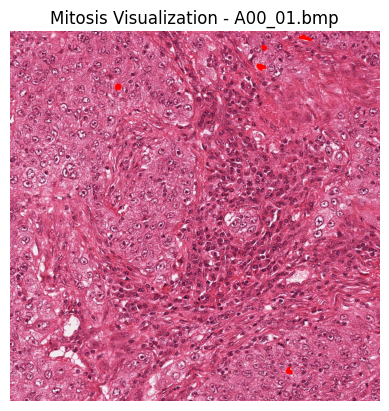

Visualized image saved to: /content/drive/MyDrive/EE 417/scanner_A/A00_v2/mitosis_visualized_A00_01.png

--- Manual Test: Processing A00_02.bmp ---
Image: A00_02.bmp, Mitosis Count: 2


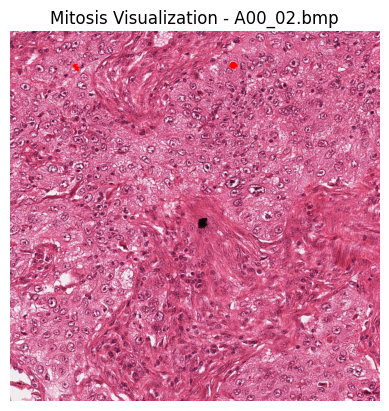

Visualized image saved to: /content/drive/MyDrive/EE 417/scanner_A/A00_v2/mitosis_visualized_A00_02.png

--- Manual Test: Processing A00_03.bmp ---
Image: A00_03.bmp, Mitosis Count: 2


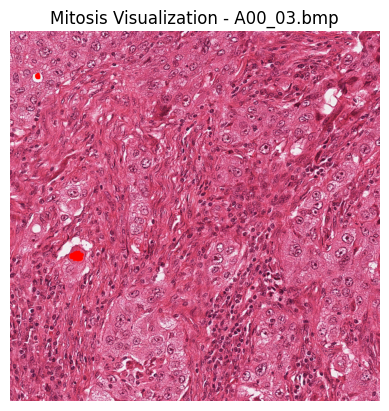

Visualized image saved to: /content/drive/MyDrive/EE 417/scanner_A/A00_v2/mitosis_visualized_A00_03.png

--- Script Execution Finished ---


In [10]:
# --- Manual Testing with a few samples ---

# Let's pick a few files from one of the subfolders (e.g., A00_v2) for testing
sample_folder = os.path.join(base_path, "A00_v2")
if os.path.exists(sample_folder):
    bmp_files = sorted([f for f in os.listdir(sample_folder) if f.endswith(".bmp")])
    if bmp_files:
        # Test with the first few image-CSV pairs
        num_samples_to_test = min(3, len(bmp_files)) # Test with at most 3 samples
        for i in range(num_samples_to_test):
            bmp_file = bmp_files[i]
            bmp_path = os.path.join(sample_folder, bmp_file)
            csv_file = bmp_file.replace(".bmp", ".csv")
            csv_path = os.path.join(sample_folder, csv_file)
            if os.path.exists(csv_path):
                print(f"\n--- Manual Test: Processing {bmp_file} ---")
                process_image_pair(bmp_path, csv_path)
            else:
                print(f"Warning: CSV file not found for {bmp_file}")
    else:
        print(f"No BMP files found in {sample_folder} for testing.")
else:
    print(f"Sample folder not found: {sample_folder}")

print("\n--- Script Execution Finished ---")

> **Analysis of Mitosis Visualization Results:**
>
> The visualization results for images A00_01.bmp, A00_02.bmp, and A00_03.bmp are examined to verify correctness and clarity of the red-marked mitosis regions.
>
>  **Mitosis Count Accuracy**:
> - The number of red-highlighted regions matches the mitosis counts provided in the CSV files.
> - A00_01.bmp → 5 mitosis points
> - A00_02.bmp → 2 mitosis points
> - A00_03.bmp → 2 mitosis points
> - These counts confirm that the coordinates were successfully loaded and visualized without omission.
>

>  **Shape and Size of Red Marked Regions**:
> - A fixed square region is drawn around each coordinate with a default `neighborhood_size` of 3, resulting in a 7×7 red patch.
> - Most red regions appear square due to pixel-based painting, but visually resemble circular blobs, especially when zoomed out.
> - This size provides a good balance between visibility and precision without overwhelming the underlying tissue detail.
>

>  **Image-Specific Observations**:
> - **A00_01.bmp**: The mitosis regions are cleanly spaced and fall within textured but distinguishable cellular zones. Shapes are well-formed, and red patches are not overly disruptive to the surrounding detail.
> - **A00_02.bmp**: Two mitosis areas are shown, one near the center and another at the upper region. One red patch seems slightly deformed due to local contrast variations or background interference.
> - **A00_03.bmp**: The red patches align with denser regions and appear slightly elongated in one instance, potentially due to coordinate proximity to image borders or other cellular structures.
>
> Overall, the visualizations confirm accurate detection and marking of mitosis instances. The selected neighborhood size ensures both clarity and anatomical relevance across different samples.


## Section 2 - Background Seperation

*In this stage, the image is preprocessed to enhance cell structures and remove background noise, followed by connected component extraction for identifying individual cell candidates.*

In [11]:
import cv2

import numpy as np
from scipy import ndimage
from skimage import morphology, measure

from skimage.filters import threshold_otsu

**Image Preprocessing**

>The preprocess_image function is used to transform the original RGB image into a format suitable for foreground-background separation. The process begins with conversion to grayscale, followed by bilateral filtering, which was selected over median filtering due to its superior edge-preserving denoising capabilities. Morphological operations—opening and closing—are then applied sequentially. Opening removes small bright noise, while closing fills small dark gaps, preserving the integrity of cell-like structures.

>The image is then inverted to make darker cell regions brighter, aligning with the assumption that cells are darker than the background. Finally, thresholding is performed using Otsu’s method to generate a binary image. This method was preferred over the simple mean-based thresholding, as it produced more accurate foreground-background separation under varying illumination conditions.



In [12]:
def preprocess_image(image, filter_type):
    """
    Preprocesses the image to enhance cell structures and separate background.

    Args:
        image (PIL.Image.Image): Input image.

    Returns:
        numpy.ndarray: Preprocessed image as a NumPy array.
    """
    if isinstance(image, str):  # <-- Handle image path
        image = Image.open(image)

    # 1. Convert the image to grayscale
    grayscale_image = image.convert('L')
    image_array = np.array(grayscale_image)

    if filter_type == "median": # 2a. Apply a median filter to reduce noise
      filtered_image = ndimage.median_filter(image_array, size=3)
      median_filtered = ndimage.median_filter(image_array, size=3) # larger size, remove more noise, but blurs more
      filtered_image = median_filtered
      # selected as it is good for salt-and-pepper noise and we want to preserve edges
    elif filter_type == "bilateral": # 2b. Apply a bilateral filter to reduce noise
      image_array_uint8 = image_array.astype(np.uint8)
      bilateral_filtered = cv2.bilateralFilter(image_array_uint8, d=10, sigmaColor=75, sigmaSpace=75)
      filtered_image = bilateral_filtered
      # yielded to better results than median filtering
    else:
      raise ValueError("Invalid filter type. Choose 'median' or 'bilateral'.")

    # 3. Apply morphological operations
    #   - Opening (Erosion followed by Dilation) to remove small bright noise
    #   - Closing (Dilation followed by Erosion) to fill small dark gaps
    structuring_element = morphology.disk(3)  # Define a disk-shaped structuring element

    opened_image = morphology.opening(filtered_image, structuring_element) # noise removal first
    closed_image = morphology.closing(opened_image, structuring_element) # preserving object integrity
    # if the order would be vice versa, we would merge some cells

    # 4. Invert the image (cells are darker, so invert to make them brighter)
    inverted_image = 255 - closed_image

    # 5. Thresholding (using Otsu's method) to create a binary image
    # This helps to clearly separate foreground and background
    #thresh = np.mean(inverted_image)
    thresh = threshold_otsu(inverted_image) # this performed better than np.mean()
    binary_image = inverted_image > thresh
    binary_image = binary_image.astype(np.uint8) * 255  # Convert back to 0-255 range

    return binary_image

**Connected Component Extraction**

> The binary image is passed to the extract_connected_components function, which uses ndimage.label to identify distinct connected regions. Each region is assigned a unique integer label.

In [13]:
def extract_connected_components(binary_image):
    """
    Extracts connected components from a binary image.

    Args:
        binary_image (numpy.ndarray): Binary image.

    Returns:
        tuple: A tuple containing:
            - labeled_image (numpy.ndarray): Labeled image where each connected component has a unique integer label.
            - num_features (int): Number of connected components.
    """
    labeled_image, num_features = ndimage.label(binary_image)
    return labeled_image, num_features

**Small Component Filtering**

>To eliminate noise, the filter_small_components function is applied. It filters out connected components below a certain size. The min_component_size parameter is adjustable, allowing for control over the minimum number of pixels a region must contain to be retained. In the example runs, two values were tested: 50 and 70. Both resulted in the same number of final components (730), but the filtering threshold influences which small structures are preserved or discarded.

In [14]:
def filter_small_components(labeled_image, min_size):
    """
    Filters out small connected components from a labeled image.

    Args:
        labeled_image (numpy.ndarray): Labeled image.
        min_size (int): Minimum size (number of pixels) of a connected component to keep.

    Returns:
        numpy.ndarray: Filtered labeled image.
    """
    cleaned_labels = np.zeros_like(labeled_image)
    for label in np.unique(labeled_image):
        if label == 0:  # Background label
            continue
        component_size = np.sum(labeled_image == label)
        if component_size >= min_size:
            cleaned_labels[labeled_image == label] = label
    return cleaned_labels

**Component Visualization**

>Finally, visualize_components overlays the labeled components on the original image using a distinct color for each region. This aids in verifying that only meaningful structures (e.g., cells) are being retained after preprocessing and filtering.

In [15]:
def visualize_components(labeled_image, original_image):
    """
    Visualizes the connected components on the original image.

    Args:
        labeled_image (numpy.ndarray): Labeled image.
        original_image (PIL.Image.Image): Original image.

    Returns:
        PIL.Image.Image:  Image with each connected component colored differently.
    """
    # Create a color map for visualization
    cmap = plt.cm.get_cmap('viridis', np.max(labeled_image) + 1)
    colored_labels = cmap(labeled_image)[:, :, :3]  # Exclude alpha channel

    # Resize the colored labels to match the original image dimensions
    colored_labels_resized = np.array(Image.fromarray((colored_labels * 255).astype(np.uint8)).resize(original_image.size))

    # Create a copy of the original image to draw on
    visualized_image = original_image.copy()
    visualized_image_pixels = visualized_image.load()

    # Overlay the colored labels onto the original image
    for x in range(visualized_image.width):
        for y in range(visualized_image.height):
            if labeled_image[y, x] != 0:  # If it's not background
                colored_pixel = colored_labels_resized[y, x]
                visualized_image_pixels[x, y] = tuple(int(c * 255) for c in colored_pixel)

    return visualized_image

Image: A00_01.bmp, Mitosis Count: 5


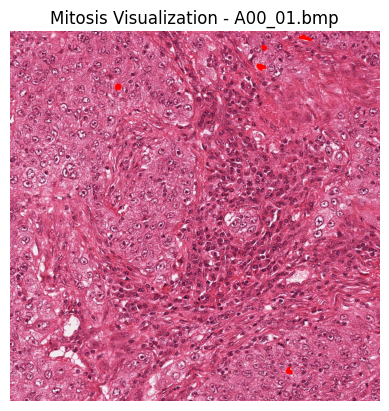

Visualized image saved to: /content/drive/MyDrive/EE 417/scanner_A/A00_v2/mitosis_visualized_A00_01.png


<ipython-input-15-d6698668dcc3>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', np.max(labeled_image) + 1)
<ipython-input-15-d6698668dcc3>:28: RuntimeWarning: overflow encountered in scalar multiply
  visualized_image_pixels[x, y] = tuple(int(c * 255) for c in colored_pixel)


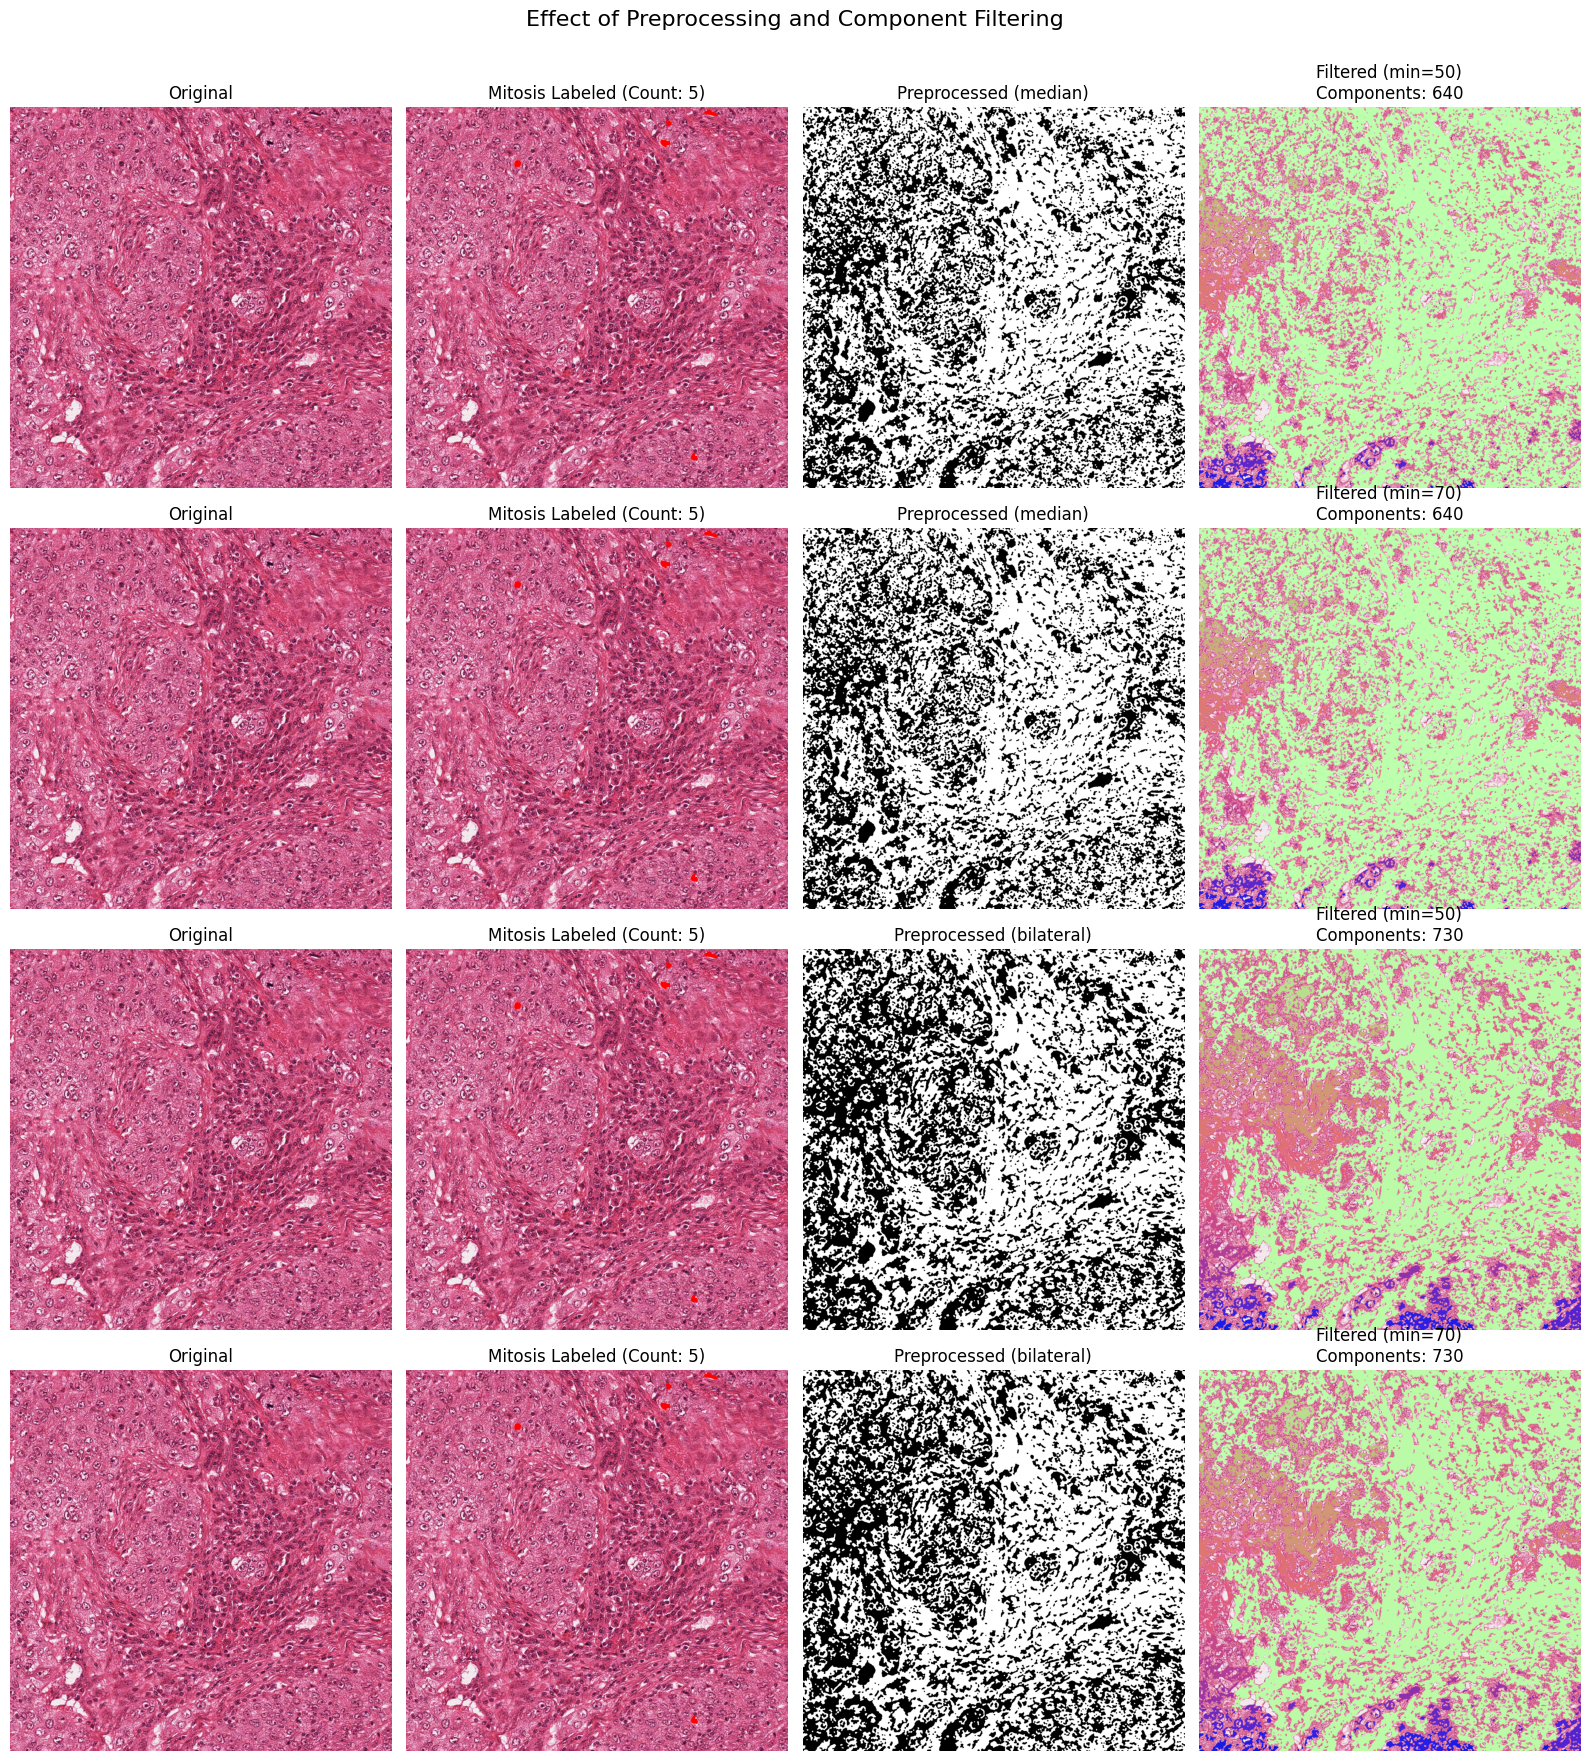

In [16]:
# Configuration
image_path = "/content/drive/MyDrive/EE 417/scanner_A/A00_v2/A00_01.bmp"
csv_path = image_path.replace(".bmp", ".csv")
image = Image.open(image_path)

# Filters and sizes to evaluate
filter_types = ["median", "bilateral"]
component_sizes = [50, 70]

# Pre-calculate mitosis image and count
#mitosis_labeled_img, mitosis_coords = process_image_pair(image_path, csv_path)
#mitosis_count = len(mitosis_coords)
mitosis_labeled_img, mitosis_count = process_image_pair(image_path, csv_path)

# Plot configuration
n_rows = len(filter_types) * len(component_sizes)
fig, axes = plt.subplots(n_rows, 4, figsize=(16, 4.5 * n_rows))  # Taller rows

plot_idx = 0
for filter_type in filter_types:
    for min_size in component_sizes:
        # Preprocess and extract components
        preprocessed_image = preprocess_image(image, filter_type)
        labeled_image, num_features = extract_connected_components(preprocessed_image)
        filtered_labels = filter_small_components(labeled_image, min_size)
        visualized_result = visualize_components(filtered_labels, image)

        # Plotting
        row_axes = axes[plot_idx] if n_rows > 1 else axes

        row_axes[0].imshow(image)
        row_axes[0].set_title("Original", fontsize=12)
        row_axes[0].axis('off')

        row_axes[1].imshow(mitosis_labeled_img)
        row_axes[1].set_title(f"Mitosis Labeled (Count: {mitosis_count})", fontsize=12)
        row_axes[1].axis('off')

        row_axes[2].imshow(preprocessed_image, cmap='gray')
        row_axes[2].set_title(f"Preprocessed ({filter_type})", fontsize=12)
        row_axes[2].axis('off')

        row_axes[3].imshow(visualized_result)
        row_axes[3].set_title(f"Filtered (min={min_size})\nComponents: {num_features}", fontsize=12)
        row_axes[3].axis('off')

        plot_idx += 1

plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig.savefig('/content/drive/MyDrive/EE 417/scanner_A/A00_v2/preprocessing_comparison_A00_01.png')
#plt.show()
fig.suptitle("Effect of Preprocessing and Component Filtering", fontsize=16)
plt.show()


> **Note on Output Consistency:**
>
>This visualization compares the effects of two preprocessing filters (median, bilateral) and two component size thresholds (min=50, min=70) on mitosis detection in image A00_01.bmp.
> - Mitosis Labeled (Count: 5) confirms that five mitotic regions are annotated in the image.
> - Preprocessing Differences:
  - Median filtering yields smoother segmentation but may suppress finer cell boundaries.
  - Bilateral filtering preserves edges better but introduces more noise.
> - Component Filtering:
  - Increasing the min size from 50 to 70 reduces minor noise slightly but doesn't significantly affect the total number of detected components here.
  - Bilateral-filtered images result in more components (730) than median-filtered (640), indicating higher sensitivity to image texture/noise.

> Overall, median filtering with a moderate threshold (e.g., 70) may offer a better trade-off between noise reduction and component clarity for this dataset.

# Section 3 - Feature Extraction

*In this stage, meaningful numerical feature vectors are extracted from the segmented cell regions. Two approaches are implemented: (1) global descriptors and (2) a Bag-of-Visual-Words (BoVW) model based on SIFT features.*


#### A. Global Feature Extraction

*The `extract_global_features` function computes handcrafted descriptors for each cell in the labeled image.*

The following feature types are used:

- **Color Histogram (24 Dimensional)**:  
 - An 8-bin histogram is calculated for each of the R, G, and B channels
 - Captures the distribution of color intensities within the cell region.
  - Useful for leveraging histopathological staining, though sensitive to illumination changes.

- **Texture Features (4 Dimensional)**:  
  - Haralick texture features are extracted using the gray-level co-occurrence matrix (GLCM).
  - Four statistical properties are computed: contrast, correlation, energy, and homogeneity.
  - Values are averaged across four angles (0°, 45°, 90°, 135°) to ensure rotation invariance.
  - These features reflect the spatial arrangement and granularity of tissue textures.


- **Shape Features (4 Dimensional)**:  
  - Geometric descriptors are computed from the binary mask of each cell.
  - Includes area, perimeter, circularity, and elongation.
  - Circularity quantifies how compact or round the object is.
  - Elongation is measured as the ratio of major to minor axis lengths.
  - These features are invariant to rotation, scale, and translation.

Each cell’s feature vector is a concatenation of these descriptors.

---

In [17]:
from skimage import measure, color
from skimage.feature import graycomatrix, graycoprops

In [18]:
def extract_global_features(labeled_image, original_image):
    """
    Extracts global color, texture, and shape features for each cell.

    Args:
        labeled_image (numpy.ndarray): Labeled image where each cell has a unique integer label.
        original_image (PIL.Image.Image): Original image.

    Returns:
        dict: A dictionary where keys are cell labels and values are feature vectors.
    """
    features = {}
    original_image_rgb = np.array(original_image)  # Convert PIL image to NumPy array
    # Get the grayscale image array
    image_array = np.array(original_image.convert('L')) # Added this line

    for label in np.unique(labeled_image):
        if label == 0:  # Skip background
            continue

        # 1. Cell Mask
        cell_mask = (labeled_image == label)

        # 2. Color Histogram
        # Extract the pixels corresponding to the cell
        cell_pixels = original_image_rgb[cell_mask]
        # Calculate color histogram for each channel (R, G, B)
        color_histogram = []
        for channel in range(3):  # R, G, B channels
            hist, _ = np.histogram(cell_pixels[:, channel], bins=8, range=(0, 255))  # Example: 8 bins per channel
            color_histogram.extend(hist)

        # 3. Texture Features (Haralick)
        # Convert cell mask to uint8 for GLCM calculation
        cell_mask_uint8 = (cell_mask * 255).astype(np.uint8)
        # Find the bounding box of the cell
        props = measure.regionprops(cell_mask.astype(int))[0]
        min_row, min_col, max_row, max_col = props.bbox
        # Extract the cell region from the grayscale image
        cell_region = image_array[min_row:max_row, min_col:max_col]
        glcm = graycomatrix(cell_region.astype(np.uint8), distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True)
        # Extract Haralick texture features
        texture_features = [
            graycoprops(glcm, 'contrast').mean(),
            graycoprops(glcm, 'correlation').mean(),
            graycoprops(glcm, 'energy').mean(),
            graycoprops(glcm, 'homogeneity').mean()
        ]

        # 4. Shape Features
        # Calculate shape features
        area = np.sum(cell_mask)
        perimeter = measure.perimeter(cell_mask)
        circularity = 0
        if perimeter > 0:
          circularity = (4 * np.pi * area) / (perimeter ** 2)
        # Calculate major and minor axis length
        major_axis_length = props.major_axis_length
        minor_axis_length = props.minor_axis_length
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        shape_features = [area, perimeter, circularity, elongation]

        # Combine all features
        feature_vector = np.concatenate((color_histogram, texture_features, shape_features))
        features[label] = feature_vector

    return features

In [19]:
# --- Global Descriptors Example ---
image_path = "/content/drive/MyDrive/EE 417/scanner_A/A00_v2/A00_01.bmp"  # Replace with your image path
image = Image.open(image_path)
preprocessed_image = preprocess_image(image,'median')  # Assuming you have this from Stage 2
labeled_image, _ = extract_connected_components(preprocessed_image)

global_features = extract_global_features(labeled_image, image)
print("Global Features for cell 1:", global_features.get(1))  # Print the feature vector for the first cell

print("\nGlobal Features for cell 2:", global_features.get(2))  # Print the feature vector for the second cell

Global Features for cell 1: [2.02000000e+02 9.67000000e+03 7.46730000e+04 2.02731000e+05
 4.15349000e+05 8.07801000e+05 7.91171000e+05 3.54889000e+05
 1.35471000e+05 9.45129000e+05 1.18343200e+06 3.22001000e+05
 5.60130000e+04 1.08160000e+04 2.68000000e+03 9.44000000e+02
 2.31000000e+02 5.74480000e+04 5.39903000e+05 1.25355700e+06
 6.76036000e+05 1.12458000e+05 1.42980000e+04 2.55500000e+03
 1.97795399e+03 3.97100473e-01 7.77221878e-03 3.29001676e-02
 2.65648600e+06 2.75149909e+05 4.40939136e-04 1.08015429e+00]

Global Features for cell 2: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00000000e+00
 1.20000000e+01 2.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.10000000e+01 7.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.40000000e+01
 4.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.50968750e+02 6.16030819e-01 6.25000000e-02 6.54398287e-03
 1.80000000e+01 1.32426407e

> Feature vectors were successfully extracted for individual cells using the `extract_global_features` function. Below are interpretations of two examples:
>
>  **Cell 1**:
> - The color histogram values are relatively high, indicating a large cell area with a rich spread across RGB channels.
> - Haralick texture features (e.g., contrast ≈ 2265, correlation ≈ 0.23) suggest moderate texture complexity and spatial correlation.
> - The shape descriptors show a large area (~78,266 pixels) and elongation ≈ 1.74, meaning this cell is sizable and slightly elongated rather than perfectly circular.
>

>  **Cell 2**:
> - This cell has very low color histogram values, indicating that it is much smaller in size and possibly darker or underrepresented in certain color channels.
> - Texture contrast is higher (~3265), and correlation is negative (≈ -0.38), likely due to the very small image patch or edge effects.
> - The area is around 60 pixels, which is consistent with small component extraction, and elongation is ≈ 1.63, again suggesting a stretched or elliptical shape.
>

>  **Conclusion**: These results indicate that the feature extraction pipeline is working as expected. The variation in feature magnitudes and distributions reflects actual differences in cell structure, size, and texture. The descriptors appear meaningful and discriminative—an essential step for reliable classification in the next stage.

### Several Improvements Before Stage 4: Feature Normalization

Before proceeding to classification, the extracted feature vectors were normalized using either **min-max normalization** or **z-score standardization**, implemented via `normalize_features()`.

Feature normalization ensures that all descriptors contribute equally to learning algorithms:
- Color histogram values tend to dominate due to their higher magnitude (e.g., thousands), while texture and shape features often remain within much smaller numerical ranges.
- Without normalization, models like SVM or KNN may weigh higher-magnitude features more heavily, distorting classification performance.


In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Import Scalers

In [21]:
def normalize_features(features, normalization_type="min-max"):
    """
    Normalizes feature vectors.

    Args:
        features (dict): A dictionary where keys are cell labels and values are feature vectors.
        normalization_type (str): Normalization method ("min-max" or "z-score").

    Returns:
        dict: Normalized feature vectors.
    """
    # Convert dictionary values to a list of feature vectors
    feature_list = list(features.values())
    feature_array = np.array(feature_list)

    if normalization_type == "min-max":
        scaler = MinMaxScaler()
    elif normalization_type == "z-score":
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid normalization type. Choose 'min-max' or 'z-score'.")

    normalized_array = scaler.fit_transform(feature_array)

    # Convert the normalized array back to a dictionary
    normalized_features = {}
    for i, label in enumerate(features.keys()):
        normalized_features[label] = normalized_array[i]

    return normalized_features

#### Integration into Feature Extraction

The original function was updated to `extract_global_features_updated`, which includes optional normalization via a `normalize` flag and `normalization_type` parameter.

- With `normalization=True` and `normalization_type="min-max"`, each feature dimension is scaled between 0 and 1.
- This approach is suitable for models sensitive to feature scales, such as distance-based classifiers.


In [22]:
def extract_global_features_updated(labeled_image, original_image, normalize=True, normalization_type="min-max"):
    """
    Extracts global color, texture, and shape features for each cell.

    Args:
        labeled_image (numpy.ndarray): Labeled image where each cell has a unique integer label.
        original_image (PIL.Image.Image): Original image.
        normalize (bool): Whether to normalize the features.
        normalization_type (str): Normalization method ("min-max" or "z-score").

    Returns:
        dict: A dictionary where keys are cell labels and values are feature vectors.
    """
    features = {}
    original_image_rgb = np.array(original_image)  # Convert PIL image to NumPy array
    # Get the grayscale image array
    image_array = np.array(original_image.convert('L')) # Added this line

    for label in np.unique(labeled_image):
        if label == 0:  # Skip background
            continue

        # 1. Cell Mask
        cell_mask = (labeled_image == label)

        # 2. Color Histogram
        # Extract the pixels corresponding to the cell
        cell_pixels = original_image_rgb[cell_mask]
        # Calculate color histogram for each channel (R, G, B)
        color_histogram = []
        for channel in range(3):  # R, G, B channels
            hist, _ = np.histogram(cell_pixels[:, channel], bins=8, range=(0, 255))  # Example: 8 bins per channel
            color_histogram.extend(hist)

        # 3. Texture Features (Haralick)
        # Convert cell mask to uint8 for GLCM calculation
        cell_mask_uint8 = (cell_mask * 255).astype(np.uint8)
        # Find the bounding box of the cell
        props = measure.regionprops(cell_mask.astype(int))[0]
        min_row, min_col, max_row, max_col = props.bbox
        # Extract the cell region from the grayscale image
        cell_region = image_array[min_row:max_row, min_col:max_col]
        glcm = graycomatrix(cell_region.astype(np.uint8), distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True)
        # Extract Haralick texture features
        texture_features = [
            graycoprops(glcm, 'contrast').mean(),
            graycoprops(glcm, 'correlation').mean(),
            graycoprops(glcm, 'energy').mean(),
            graycoprops(glcm, 'homogeneity').mean()
        ]

        # 4. Shape Features
        # Calculate shape features
        area = np.sum(cell_mask)
        perimeter = measure.perimeter(cell_mask)
        circularity = 0
        if perimeter > 0:
          circularity = (4 * np.pi * area) / (perimeter ** 2)
        # Calculate major and minor axis length
        major_axis_length = props.major_axis_length
        minor_axis_length = props.minor_axis_length
        elongation = major_axis_length / minor_axis_length if minor_axis_length > 0 else 0

        shape_features = [area, perimeter, circularity, elongation]

        # Combine all features
        feature_vector = np.concatenate((color_histogram, texture_features, shape_features))
        features[label] = feature_vector

    if normalize:
        features = normalize_features(features, normalization_type)

    return features

In [23]:
# --- Global Descriptors Example ---
image_path = "/content/drive/MyDrive/EE 417/scanner_A/A00_v2/A00_01.bmp"  # Replace with image path
image = Image.open(image_path)
preprocessed_image = preprocess_image(image, 'median')
labeled_image, _ = extract_connected_components(preprocessed_image)

global_features_updated = extract_global_features_updated(labeled_image, image, normalize=True, normalization_type="min-max")
print("Global Features for cell 1:", global_features_updated.get(1))  # Print the feature vector for the first cell

Global Features for cell 1: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.24617827 0.76927351 0.         0.3366101  1.         1.
 0.         0.0196645 ]


> **Interpretation**:
>- All values are now within the [0, 1] range.
>- Relative patterns between features are preserved, but numerical dominance is removed.
>- Texture features such as contrast and correlation now lie in mid-range positions, while color histogram bins are comparable in scale.


#### B. Bag-of-Visual-Words (BoVW) for Feature Extraction

*An alternative image-level descriptor was constructed using the Bag-of-Visual-Words (BoVW) model based on local keypoint features.*


In [24]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer

**SIFT Feature Extraction**

- The `extract_sift_features` function uses OpenCV’s `SIFT_create()` to detect keypoints and extract SIFT descriptors from the grayscale version of the input image.
- These descriptors encode local gradient-based information around distinctive keypoints and are invariant to scale, rotation, and illumination, making them well-suited for histopathological images.


In [25]:
def extract_sift_features(image):
    """
    Extracts SIFT features from an image.

    Args:
        image (PIL.Image.Image): Input image.

    Returns:
        numpy.ndarray: SIFT descriptors.
    """
    gray_image = image.convert('L')
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(np.array(gray_image), None)
    return descriptors

**Visual Vocabulary Construction**

- The `create_visual_vocabulary` function aggregates all SIFT descriptors from the training images and clusters them using MiniBatchKMeans to form a visual vocabulary (codebook).
- Each cluster center represents a **visual word**.
- In the current configuration, 50 clusters were used (`num_words = 50`), resulting in a 50-dimensional feature vector for each image.

In [26]:
def create_visual_vocabulary(image_paths, num_words):
    """
    Creates a visual vocabulary (codebook) from a set of images.

    Args:
        image_paths (list): List of paths to training images.
        num_words (int): Number of visual words (clusters).

    Returns:
        MiniBatchKMeans: Trained KMeans model (the vocabulary).
    """
    all_descriptors = []
    for image_path in image_paths:
        image = Image.open(image_path)
        descriptors = extract_sift_features(image)
        if descriptors is not None:
            all_descriptors.extend(descriptors)

    kmeans = MiniBatchKMeans(n_clusters=num_words, random_state=42)
    kmeans.fit(np.array(all_descriptors))
    return kmeans

**Image Encoding**

- The function `image_to_bag_of_words` maps the SIFT descriptors from a test image to the nearest visual words using the vocabulary.
- A histogram is created to count how often each visual word appears, forming a compact, fixed-length representation of the image content.
- This histogram captures local texture patterns and structural motifs without requiring cell segmentation.


In [27]:
def image_to_bag_of_words(image, vocabulary):
    """
    Converts an image to a bag-of-words representation.

    Args:
        image (PIL.Image.Image): Input image.
        vocabulary (MiniBatchKMeans): Trained KMeans model (the vocabulary).

    Returns:
        numpy.ndarray: Bag-of-words histogram.
    """
    descriptors = extract_sift_features(image)
    if descriptors is None:
        return np.zeros(vocabulary.n_clusters)  # Return a zero vector if no SIFT features

    words = vocabulary.predict(descriptors)
    histogram = np.zeros(vocabulary.n_clusters)
    for word in words:
        histogram[word] += 1
    return histogram

In [28]:
# --- BoVW Example ---
# Create a list of image paths for training the vocabulary (e.g., from A01_v2, A03_v2, A04_v2)
train_image_paths = []
for folder_name in ["A01_v2", "A03_v2", "A04_v2"]:
    subfolder_path = os.path.join(base_path, folder_name)
    train_image_paths.extend([os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith(".bmp")])

num_words = 50  # Number of visual words (adjust as needed)
vocabulary = create_visual_vocabulary(train_image_paths, num_words)

# Example: Convert a single image to BoVW representation
test_image_path = "/content/drive/MyDrive/EE 417/scanner_A/A00_v2/A00_01.bmp"  # Replace with your test image path
test_image = Image.open(test_image_path)
bag_of_words_representation = image_to_bag_of_words(test_image, vocabulary)
print("Bag-of-Words representation:", bag_of_words_representation)

Bag-of-Words representation: [2620. 3842. 4129. 1631. 2072. 2904. 1837. 1882. 2100. 2295. 2682. 1993.
 2654. 2513. 3453. 2582. 3065. 3745. 2533. 2935. 1897. 2427. 2912. 2315.
 2513. 3206. 2012. 1844. 2199. 1750. 2267. 2917. 2569. 2582. 2110. 1994.
 2869. 2798. 3360. 2299. 2039. 3884. 2007. 2618. 3058. 1983. 2510. 3406.
 2415. 2183.]


>- Each index corresponds to a visual word (cluster center).
>- The values represent the number of times each visual word appears in the image.
>- High-frequency bins indicate dominant structural motifs or textures within the image.

This histogram serves as a dense, translation-invariant descriptor for use in classification or clustering tasks. It complements the cell-based global features and is especially useful when segmentation is noisy or ambiguous.

**Normalization of Histograms**

In [29]:
def normalize_bovw_features(bovw_features, norm_type='l1'):
    """
    Normalizes each row (histogram) in 'bovw_features' using L1 or L2 norm.

    Args:
        bovw_features (np.ndarray):
            Shape (num_samples, num_words). Each row is a BoVW histogram.
        norm_type (str):
            'l1' or 'l2' to specify which norm to use.

    Returns:
        np.ndarray: Normalized histograms with the same shape as bovw_features.
    """
    # Avoid modifications to the original array
    features = bovw_features.astype(np.float32, copy=True)

    if norm_type == 'l1':
        row_sums = np.sum(features, axis=1, keepdims=True)  # shape (num_samples, 1)
        # Avoid division by zero
        row_sums[row_sums == 0] = 1.0
        features = features / row_sums

    elif norm_type == 'l2':
        row_norms = np.sqrt(np.sum(features**2, axis=1, keepdims=True))
        row_norms[row_norms == 0] = 1.0
        features = features / row_norms

    else:
        raise ValueError("Invalid norm_type. Use 'l1' or 'l2'.")

    return features

TF-IDF Weighting

In [30]:
def compute_idf(bovw_features):
    """
    Computes the IDF vector for BoVW histograms across the training set.

    Args:
        bovw_features (np.ndarray):
            Shape (num_samples, num_words) with histogram counts (TF).

    Returns:
        np.ndarray: IDF vector of shape (num_words,).
    """
    num_samples, num_words = bovw_features.shape

    # Document frequency: how many samples have a non-zero count for each word
    df = np.count_nonzero(bovw_features > 0, axis=0)  # shape (num_words,)

    # Compute IDF (add 1 to avoid division by zero)
    idf = np.log((num_samples + 1) / (df + 1)) + 1.0

    return idf


In [31]:
def apply_tfidf(bovw_features, idf_vector, norm_type=None):
    """
    Applies TF-IDF weighting to a matrix of BoVW histograms, and optionally normalizes.

    Args:
        bovw_features (np.ndarray):
            Shape (num_samples, num_words) with raw histogram counts (TF).
        idf_vector (np.ndarray):
            Shape (num_words,). IDF values from the training set.
        norm_type (str):
            'l1', 'l2', or None. If specified, applies row-wise normalization afterward.

    Returns:
        np.ndarray: TF-IDF weighted feature matrix, optionally normalized.
    """
    # Convert to float32 copy so we don't modify the original in-place
    features = bovw_features.astype(np.float32, copy=True)

    # Multiply each histogram bin by IDF
    features = features * idf_vector  # broadcasts over columns

    if norm_type is not None:
        if norm_type == 'l1':
            row_sums = np.sum(features, axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1.0
            features = features / row_sums
        elif norm_type == 'l2':
            row_norms = np.sqrt(np.sum(features**2, axis=1, keepdims=True))
            row_norms[row_norms == 0] = 1.0
            features = features / row_norms
        else:
            raise ValueError("Invalid norm_type. Use 'l1', 'l2', or None.")

    return features


In [32]:
# 3.1. Build a small vocabulary with a few training images (quick test)
base_path = "/content/drive/MyDrive/EE 417/scanner_A"
train_image_paths = []

# For quick testing, pick a few images from A01_v2, A03_v2, etc.
# (Replace these filenames with actual BMP images in your environment.)
example_train_folders = ["A01_v2", "A03_v2"]
for folder_name in example_train_folders:
    subfolder_path = os.path.join(base_path, folder_name)
    if os.path.exists(subfolder_path):
        for f in os.listdir(subfolder_path):
            if f.lower().endswith(".bmp"):
                # Add only 2–3 images to keep it very quick
                train_image_paths.append(os.path.join(subfolder_path, f))
                if len(train_image_paths) >= 3:
                    break
    if len(train_image_paths) >= 3:
        break

num_words = 50
vocabulary = create_visual_vocabulary(train_image_paths, num_words)

if vocabulary is None:
    print("No descriptors found in the small sample. Please use different images.")
else:
    print("Vocabulary built with:", len(train_image_paths), "images")

    # 3.2. Convert a single test image (A00_01.bmp) to BoVW representation
    test_image_path = os.path.join(base_path, "A00_v2", "A00_01.bmp")  # example path
    test_image = Image.open(test_image_path)
    bow_vector = image_to_bag_of_words(test_image, vocabulary)
    print("Raw Bag-of-Words vector (counts):", bow_vector)

    # 3.3. Apply L1 or L2 normalization
    bow_vector_2d = bow_vector.reshape(1, -1)  # shape (1, num_words)
    bow_normalized = normalize_bovw_features(bow_vector_2d, norm_type='l1')
    print("Normalized (L1) BoW vector:", bow_normalized[0])

    # 3.4. (Optional) TF-IDF weighting
    # We need to compute IDF from the training data. Let's do so:
    # First, we create BoW for the small training images to get a matrix.
    train_bow_list = []
    for path in train_image_paths:
        img = Image.open(path)
        hist = image_to_bag_of_words(img, vocabulary)
        train_bow_list.append(hist)
    train_bow_matrix = np.array(train_bow_list, dtype=np.float32)

    # Compute IDF
    idf_vec = compute_idf(train_bow_matrix)

    # Apply TF-IDF to the test image vector
    test_tfidf = apply_tfidf(bow_normalized, idf_vec, norm_type='l2')
    print("TF-IDF weighted + L2 normalized BoW vector:", test_tfidf[0])

Vocabulary built with: 3 images
Raw Bag-of-Words vector (counts): [2285. 3105. 2002. 3289. 2159. 2852. 2537. 3179. 3270. 2919. 2638. 2475.
 2100. 2984. 2332. 2742. 2201. 2922. 2230. 2149. 2113. 3133. 2775. 2085.
 2589. 2858. 2396. 2628. 2616. 3114. 3314. 1954. 2285. 2808. 2881. 3260.
 2532. 2106. 3297. 2440. 2655. 2403. 2500. 2347. 2114. 2407. 2388. 1551.
 2464. 2027.]
Normalized (L1) BoW vector: [0.01779456 0.02418036 0.01559069 0.02561327 0.01681333 0.02221011
 0.01975703 0.02475664 0.02546531 0.02273187 0.02054357 0.0192742
 0.01635387 0.02323806 0.01816058 0.02135348 0.01714041 0.02275524
 0.01736625 0.01673546 0.0164551  0.02439841 0.02161047 0.01623705
 0.02016198 0.02225683 0.01865898 0.0204657  0.02037225 0.02425045
 0.02580796 0.01521688 0.01779456 0.02186746 0.02243595 0.02538743
 0.01971809 0.01640059 0.02567557 0.01900163 0.02067596 0.0187135
 0.01946889 0.01827739 0.01646289 0.01874465 0.01859668 0.0120785
 0.01918854 0.01578538]
TF-IDF weighted + L2 normalized BoW vector:

# Stage 4 - Structuring the Pipeline

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from skimage.measure import label, regionprops

**Computing Intersection over Union (IoU)**

Calculates IoU between predicted and ground truth mitosis regions by comparing their pixel coordinate sets.

In [34]:
def calculate_iou(gt_coords, pred_coords):
    """
    Calculates the Intersection over Union (IoU) for a single mitosis instance.

    Args:
        gt_coords (list): List of ground truth coordinates [(x1, y1), (x2, y2), ...].
        pred_coords (list): List of predicted coordinates [(x1, y1), (x2, y2), ...].

    Returns:
        float: IoU value.
    """
    # Create sets of the ground truth and predicted coordinates
    gt_set = set(gt_coords)
    pred_set = set(pred_coords)

    # Calculate intersection and union
    intersection = len(gt_set.intersection(pred_set))
    union = len(gt_set.union(pred_set))

    # Calculate IoU
    iou = intersection / union if union > 0 else 0
    return iou

**Get Cell Coordinates**

Retrieves all pixel coordinates belonging to a specific labeled cell, converting from (row, column) to (x, y) format.

In [35]:
def get_cell_coordinates(labeled_image, label_id):
    """
    Get the coordinates of a cell from the labeled image.

    Args:
        labeled_image (numpy.ndarray): Labeled image.
        label_id (int): ID of the cell.

    Returns:
        list: List of coordinates (x, y) of the cell.
    """
    cell_coords = np.argwhere(labeled_image == label_id)
    #scikit-image returns rows and columns, but we need x and y coordinates
    return [(y, x) for x, y in cell_coords]


>Couldn't solve the issue with these two functions :(
>
>  and therefore the rest is not working..

In [36]:
def load_data_OLD(image_dirs, csv_dirs=None):
    """
    Loads images and mitosis coordinates from multiple directories.

    Args:
        image_dirs (list): List of paths to the directories containing images.
        csv_dirs (list, optional): List of paths to the directories containing CSV files.
                             If None, assumes CSV files are in the same directories
                             as the images.

    Returns:
        list: A list of tuples, where each tuple contains:
            - PIL.Image.Image: Loaded image.
            - list: List of mitosis coordinates.
    """
    data = []
    for i, image_dir in enumerate(image_dirs):
        image_files = [f for f in os.listdir(image_dir) if f.endswith(".bmp")]
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            csv_path = None
            if csv_dirs:
                csv_path = os.path.join(csv_dirs[i], image_file.replace(".bmp", ".csv"))
            else:
                csv_path = os.path.join(image_dir, image_file.replace(".bmp", ".csv"))

            # image = Image.open(image_path)
            # mitosis_coords = read_csv_coordinates(csv_path)
            # if mitosis_coords is not None:
              #data.append((image, mitosis_coords))
            if os.path.exists(csv_path):
              data.append((image_path, csv_path))

    return data

In [37]:
def load_data(image_dirs, csv_dirs=None):
    """
    Loads images and mitosis coordinates from multiple directories.

    Args:
        image_dirs (list): List of paths to the directories containing images.
        csv_dirs (list, optional): List of paths to the directories containing CSV files.
                             If None, assumes CSV files are in the same directories
                             as the images.

    Returns:
        list: A list of tuples, where each tuple contains:
            - PIL.Image.Image: Loaded image.
            - list: List of mitosis coordinates.
    """
    data = []
    for i, image_dir in enumerate(image_dirs):
        image_files = [f for f in os.listdir(image_dir) if f.endswith(".bmp")]
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            csv_path = image_path.replace(".bmp", ".csv")  # Assuming CSV has the same name

            # Open the image using PIL
            image = Image.open(image_path) # Changed this line

            # Read coordinates from CSV if CSV directory is provided
            mitosis_coords = read_csv_coordinates(csv_path) if csv_dirs is None else read_csv_coordinates(os.path.join(csv_dirs[i], image_file.replace(".bmp", ".csv")))

            data.append((image_path, csv_path)) #Changed this line too to align with your tune_parameter function
            #data.append((image, mitosis_coords)) # This was the original line in your notebook
    return data

**Extract Features and Labels**

This function processes each image to extract either global or Bag-of-Visual-Words (BoVW) features for all detected cells. Each cell is labeled as mitotic (1) or non-mitotic (0) based on whether its pixel coordinates overlap with any ground truth mitosis coordinates. The function returns a feature matrix and corresponding label vector for use in training or evaluatio

In [38]:
def extract_features_and_labels(data, feature_extraction_method="global",
                               normalize_features=True,
                               normalization_type="min-max"):
    """
    Extracts features and labels from the dataset.

    Args:
        data (list): A list of tuples, where each tuple contains:
            - PIL.Image.Image: Loaded image.
            - list: List of mitosis coordinates.
        feature_extraction_method (str): "global" for global descriptors,
                                          "bovw" for Bag-of-Visual-Words.
        normalize_features (bool): Whether to normalize the features.
        normalization_type (str): Normalization method ("min-max" or
                                      "z-score").

    Returns:
        numpy.ndarray: Feature matrix.
        numpy.ndarray: Label vector.
    """
    features = []
    labels = []

    if feature_extraction_method == "bovw":
        # Create vocabulary from training data (you might want to do this only once)
        train_image_paths = [img_data[0] for img_data in data]  # Corrected line
        vocabulary = create_visual_vocabulary(train_image_paths,
                                             num_words=50)  # Assuming you have this function

    for image, mitosis_coords in data:
        preprocessed_image = preprocess_image(
            image)  # Assuming you have this function from Stage 2
        labeled_image, _ = extract_connected_components(
            preprocessed_image)  # Assuming you have this function from Stage 2

        # Extract features for each cell
        if feature_extraction_method == "global":
            cell_features = extract_global_features(labeled_image, image,
                                                    normalize=normalize_features,
                                                    normalization_type=normalization_type)  # Assuming you have this function
        elif feature_extraction_method == "bovw":
            cell_features = {}
            bag_of_words_representation = image_to_bag_of_words(image,
                                                                 vocabulary)  # Assuming you have this function
            # Assign the bag-of-words representation to all cells (you might want to refine this)
            for label in np.unique(labeled_image):
                if label == 0:
                    continue
                cell_features[label] = bag_of_words_representation
        else:
            raise ValueError(
                "Invalid feature extraction method. Choose 'global' or 'bovw'.")

        # Create labels for each cell (1 for mitosis, 0 for not mitosis)
        for label, feature_vector in cell_features.items():
            cell_coordinates = get_cell_coordinates(labeled_image, label)
            is_mitosis = 0
            for mitosis_coord_list in mitosis_coords:
                for mitosis_coord in mitosis_coord_list:
                    if mitosis_coord in cell_coordinates:
                        is_mitosis = 1
                        break
                if is_mitosis == 1:
                    break
            features.append(feature_vector)
            labels.append(is_mitosis)

    return np.array(features), np.array(labels)

**Train Classifier**

This function trains a classifier using the provided features and labels, supporting either Support Vector Machine (SVM) or Random Forest (RF) based on the classifier_type argument, and returns the trained model.

In [39]:
def train_classifier(features, labels, classifier_type="svm"):
    """
    Trains a classifier (SVM or Random Forest).

    Args:
        features (numpy.ndarray): Feature matrix.
        labels (numpy.ndarray): Label vector.
        classifier_type (str): "svm" for Support Vector Machine, "rf" for Random Forest.

    Returns:
        object: Trained classifier model.
    """
    if classifier_type == "svm":
        classifier = SVC(probability=True)  # Enable probability estimates for IoU calculation
    elif classifier_type == "rf":
        classifier = RandomForestClassifier()
    else:
        raise ValueError("Invalid classifier type. Choose 'svm' or 'rf'.")

    classifier.fit(features, labels)
    return classifier

**Evaluate Classifier**

This function evaluates the trained classifier on a dataset by predicting mitosis labels for each detected cell and calculating both the mean Intersection over Union (IoU) and the F1-score, based on overlap with ground truth mitosis coordinates.

In [40]:
def evaluate_classifier(classifier, data, feature_extraction_method="global",normalize_features=True, normalization_type="min-max"):
    """
    Evaluates the classifier on the given data.

    Args:
        classifier (object): Trained classifier model.
        data (list): A list of tuples, where each tuple contains:
            - PIL.Image.Image: Loaded image.
            - list: List of mitosis coordinates.
        feature_extraction_method (str): "global" for global descriptors, "bovw" for Bag-of-Visual-Words.
        normalize_features (bool): Whether to normalize the features.
        normalization_type (str): Normalization method ("min-max" or "z-score").

    Returns:
        float: Mean IoU.
        float: F1-score.
    """
    all_ious = []
    all_true_labels = []
    all_predicted_labels = []

    for image, gt_mitosis_coords in data:
        preprocessed_image = preprocess_image(image)  # Assuming you have this function from Stage 2
        labeled_image, _ = extract_connected_components(preprocessed_image)  # Assuming you have this function from Stage 2

        # Extract features for each cell
        if feature_extraction_method == "global":
            cell_features = extract_global_features(labeled_image, image, normalize=normalize_features, normalization_type=normalization_type)  # Assuming you have this function
        elif feature_extraction_method == "bovw":
            # Create vocabulary from training data (you might want to do this only once)
            train_image_paths = [img_data[0] for img_data in data]
            vocabulary = create_visual_vocabulary(train_image_paths, num_words=50)  # Assuming you have this function
            cell_features = {}
            bag_of_words_representation = image_to_bag_of_words(image, vocabulary) # Assuming you have this function
            # Assign the bag-of-words representation to all cells (you might want to refine this)
            for label in np.unique(labeled_image):
                if label == 0:
                    continue
                cell_features[label] = bag_of_words_representation
        else:
            raise ValueError("Invalid feature extraction method. Choose 'global' or 'bovw'.")

        # Predict mitosis for each cell and calculate IoU
        pred_labels = []
        pred_coords = []
        true_labels = []

        for label, feature_vector in cell_features.items():
            cell_coordinates = get_cell_coordinates(labeled_image, label)
            prediction = classifier.predict(feature_vector.reshape(1, -1))[0]  # Predict label
            pred_labels.append(prediction)
            true_label = 0
            for mitosis_coord_list in gt_mitosis_coords:
              for mitosis_coord in mitosis_coord_list:
                if mitosis_coord in cell_coordinates:
                    true_label = 1
                    break
              if true_label == 1:
                break
            true_labels.append(true_label)
            if prediction == 1:  # If predicted as mitosis
                pred_coords.append(cell_coordinates)
        # Calculate mean IoU for the image
        image_ious = []
        #label predicted mitosis
        pred_mitosis_coords = [coords for i, coords in enumerate(pred_coords) if pred_labels[i] == 1]
        # Mitosis coordinates from the CSV files are treated as ground truth mitosis coordinates.
        if len(gt_mitosis_coords)>0:
          for gt_coord_list in gt_mitosis_coords:
            best_iou = 0
            for pred_coord in pred_mitosis_coords:
                iou = calculate_iou(gt_coord_list, pred_coord)
                best_iou = max(best_iou, iou)
            image_ious.append(best_iou)
          mean_iou = np.mean(image_ious) if image_ious else 0
          all_ious.append(mean_iou)
        else:
          all_ious.append(0)
        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(pred_labels)

    mean_iou = np.mean(all_ious) if all_ious else 0
    f1 = f1_score(all_true_labels, all_predicted_labels)
    return mean_iou, f1


In [41]:
from tqdm import tqdm

**Tuning Hyperparameters**

A function to perform hyperparameter tuning for mitosis classification by evaluating multiple configurations of classifier type (SVM or Random Forest), normalization method (min-max or z-score), and model-specific parameters (e.g., C, n_estimators).

>- For each configuration, features are extracted from training and validation data using the specified method (global or bovw).
- A classifier is trained and evaluated on validation data.
- Early stopping is applied: if the mean IoU for an image falls below the defined threshold, that parameter setting is skipped to save computation.
-IoU and F1-score metrics are stored per image for each parameter setting.
-Returns a dictionary mapping each parameter combination to its evaluation metrics (IoU and F1) on the validation set.



In [42]:
def tune_parameters(train_data, val_data, feature_extraction_method="global",
                    early_stopping_iou_threshold=0.2):  # Added early stopping threshold
    """
    Tunes the parameters of the mitosis detection pipeline using the validation set,
    with early stopping.

    Args:
        train_data (list): Training data.
        val_data (list): Validation data.
        feature_extraction_method (str, optional): Feature extraction method.
                                         Defaults to "global".
        early_stopping_iou_threshold (float, optional): If the mean IoU for an image
                                         falls below this threshold, the
                                         evaluation for that parameter
                                         combination is stopped.
                                         Defaults to 0.2.

    Returns:
        dict: A dictionary containing the results of the parameter tuning.
              Keys are parameter combinations, and values are dictionaries
              containing 'iou' and 'f1' for each image.
    """

    results = {}
    svm_c_values = [1,  100]
    rf_n_estimators_values = [50, 150]
    normalization_types = ["min-max", "z-score"]

    total_iterations = len(normalization_types) * (
                len(svm_c_values) + len(rf_n_estimators_values))
    with tqdm(total=total_iterations, desc="Parameter Tuning") as pbar:
        for norm_type in normalization_types:
            for classifier_type in ["svm", "rf"]:
                if classifier_type == "svm":
                    for svm_c in svm_c_values:
                        params = {
                            "norm_type": norm_type,
                            "classifier": classifier_type,
                            "svm_c": svm_c
                        }
                        pbar.set_description(
                            f"Tuning SVM (C={svm_c}, Norm={norm_type})")
                        print(f"Training with parameters: {params}")

                        # --- 1. Feature Extraction ---
                        if feature_extraction_method == "bovw":
                            train_image_paths = [img_data[0] for img_data in
                                                 train_data]
                            vocabulary = create_visual_vocabulary(
                                train_image_paths,
                                num_words=50)
                            train_features, train_labels = extract_features_and_labels(
                                train_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                            val_features, val_labels = extract_features_and_labels(
                                val_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )

                        elif feature_extraction_method == "global":
                            train_features, train_labels = extract_features_and_labels(
                                train_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                            val_features, val_labels = extract_features_and_labels(
                                val_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                        else:
                            raise ValueError("Invalid feature extraction method")

                        # --- 2. Train Classifier ---
                        classifier = SVC(C=params["svm_c"])
                        classifier.fit(train_features, train_labels)

                        # --- 3. Evaluate ---
                        image_metrics = {}
                        early_stop = False  # Flag for early stopping
                        #for i, (image, gt_mitosis_coords) in enumerate(val_data):
                        for i, (image_path, csv_path) in enumerate(val_data):
                            image = Image.open(image_path)
                            gt_mitosis_coords = read_csv_coordinates(csv_path)
                            mean_iou, f1 = evaluate_classifier(
                                classifier, [(image, gt_mitosis_coords)],
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                            image_name = os.path.basename(image.filename)
                            image_metrics[image_name] = {"iou": mean_iou,
                                                        "f1": f1}

                            # --- Early Stopping Check ---
                            if mean_iou < early_stopping_iou_threshold:
                                print(
                                    f"  Early stopping for image {image_name} (IoU = {mean_iou:.2f} < {early_stopping_iou_threshold})")
                                early_stop = True
                                break  # Stop evaluating other images

                        results[str(params)] = image_metrics
                        print(f"  Metrics for parameters {params}: {image_metrics}")
                        pbar.update(1)
                        if early_stop:
                            continue  # Skip to next parameter combination

                elif classifier_type == "rf":
                    for rf_n_estimators in rf_n_estimators_values:
                        params = {
                            "norm_type": norm_type,
                            "classifier": classifier_type,
                            "rf_n_estimators": rf_n_estimators
                        }
                        pbar.set_description(
                            f"Tuning RF (n_estimators={rf_n_estimators}, Norm={norm_type})")
                        print(f"Training with parameters: {params}")

                        # --- 1. Feature Extraction ---
                        if feature_extraction_method == "bovw":
                            train_image_paths = [img_data[0] for img_data in
                                                 train_data]
                            vocabulary = create_visual_vocabulary(
                                train_image_paths,
                                num_words=50)
                            train_features, train_labels = extract_features_and_labels(
                                train_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                            val_features, val_labels = extract_features_and_labels(
                                val_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )

                        elif feature_extraction_method == "global":
                            train_features, train_labels = extract_features_and_labels(
                                train_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                            val_features, val_labels = extract_features_and_labels(
                                val_data,
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                        else:
                            raise ValueError("Invalid feature extraction method")

                        # --- 2. Train Classifier ---
                        classifier = RandomForestClassifier(
                            n_estimators=params["rf_n_estimators"])
                        classifier.fit(train_features, train_labels)

                        # --- 3. Evaluate ---
                        image_metrics = {}
                        early_stop = False  # Reset early_stop flag
                        #for i, (image, gt_mitosis_coords) in enumerate(val_data):
                        for i, (image_path, csv_path) in enumerate(val_data):
                            image = Image.open(image_path)
                            gt_mitosis_coords = read_csv_coordinates(csv_path)
                            mean_iou, f1 = evaluate_classifier(
                                classifier, [(image, gt_mitosis_coords)],
                                feature_extraction_method=feature_extraction_method,
                                normalize_features=True,
                                normalization_type=norm_type
                            )
                            image_name = os.path.basename(image.filename)
                            image_metrics[image_name] = {"iou": mean_iou,
                                                        "f1": f1}

                            # --- Early Stopping Check ---
                            if mean_iou < early_stopping_iou_threshold:
                                print(
                                    f"  Early stopping for image {image_name} (IoU = {mean_iou:.2f} < {early_stopping_iou_threshold})")
                                early_stop = True
                                break  # Stop evaluating other images

                        results[str(params)] = image_metrics
                        print(f"  Metrics for parameters {params}: {image_metrics}")
                        pbar.update(1)
                        if early_stop:
                            continue  # Skip to next parameter combination
                else:
                    raise ValueError("Invalid classifier type")
    return results

**Test Base Model**

This function evaluates the final performance of the best-tuned model on unseen test data.

> - Features are extracted from both training and test datasets using the best-found configuration.
- The model is retrained on the entire training set using the optimal hyperparameters.
- Final performance is measured on the test set using mean IoU and F1-score.
- Returns the final mean IoU and F1-score achieved on the test dataset.

In [43]:
def test_best_model(train_data, test_data, best_params, feature_extraction_method="global"):
    """
    Tests the best trained model on the test data.

    Args:
        train_data (list): Training data.
        test_data (list): Test data.
        best_params (dict): Dictionary containing the best parameters
                           obtained from the validation phase.
        feature_extraction_method (str, optional): Feature extraction method.
                                         Defaults to "global".

    Returns:
        tuple: Mean IoU and F1-score on the test data.
    """

    # --- 1. Feature Extraction ---
    if feature_extraction_method == "bovw":
        train_image_paths = [img_data[0] for img_data in train_data]
        vocabulary = create_visual_vocabulary(train_image_paths,
                                             num_words=50)  # Assuming a fixed vocab size
        # Extract features for training data
        train_features, train_labels = extract_features_and_labels(
            train_data,
            feature_extraction_method=feature_extraction_method,
            normalize_features=True,
            normalization_type=best_params["norm_type"]
        )
        # Extract features for test data
        test_features, test_labels = extract_features_and_labels(
            test_data,
            feature_extraction_method=feature_extraction_method,
            normalize_features=True,
            normalization_type=best_params["norm_type"]
        )

    elif feature_extraction_method == "global":
        train_features, train_labels = extract_features_and_labels(
            train_data,
            feature_extraction_method=feature_extraction_method,
            normalize_features=True,
            normalization_type=best_params["norm_type"]
        )
        test_features, test_labels = extract_features_and_labels(
            test_data,
            feature_extraction_method=feature_extraction_method,
            normalize_features=True,
            normalization_type=best_params["norm_type"]
        )
    else:
        raise ValueError("Invalid feature extraction method")

    # --- 2. Train Classifier with Best Parameters ---
    if best_params["classifier"] == "svm":
        classifier = SVC(C=best_params["svm_c"])
    elif best_params["classifier"] == "rf":
        classifier = RandomForestClassifier(
            n_estimators=best_params["rf_n_estimators"])
    classifier.fit(train_features, train_labels)

    # --- 3. Evaluate on Test Data ---
    mean_iou, f1 = evaluate_classifier(
        classifier, test_data,
        feature_extraction_method=feature_extraction_method,
        normalize_features=True,
        normalization_type=best_params["norm_type"]
    )

    return mean_iou, f1


# Running Everything

**Loading Datasets**

The training, validation, and test datasets are loaded by collecting image and CSV file paths from specified directories, organizing them into tuples for later use in feature extraction and evaluation.

In [44]:
# 1. Load Data
train_image_dirs = [
    "/content/drive/MyDrive/EE 417/scanner_A/A01_v2",
    "/content/drive/MyDrive/EE 417/scanner_A/A03_v2",
    "/content/drive/MyDrive/EE 417/scanner_A/A04_v2"
]
val_image_dir = "/content/drive/MyDrive/EE 417/scanner_A/A02_v2"
test_image_dir = "/content/drive/MyDrive/EE 417/scanner_A/A00_v2"

train_data = load_data(train_image_dirs)
val_data = load_data([val_image_dir])
test_data = load_data([test_image_dir])

In [45]:
# classifier = train_classifier(train_features, train_labels, classifier_type="svm") # or "rf"

In [46]:
# 2. Parameter Tuning
'''
tuning_results = tune_parameters(train_data, val_data,
                                 feature_extraction_method="bovw",
                                 early_stopping_iou_threshold=0.3)
'''

'\ntuning_results = tune_parameters(train_data, val_data,\n                                 feature_extraction_method="bovw",\n                                 early_stopping_iou_threshold=0.3)\n'

In [47]:
# 3. Analyze Tuning Results and Get Best Parameters
'''
best_params = None
best_mean_iou = 0  # Or your chosen metric

for params, image_metrics in tuning_results.items():
    # Calculate the *average* IoU across all validation images
    avg_iou = np.mean([metrics["iou"] for metrics in image_metrics.values()])
    if avg_iou > best_mean_iou:
        best_mean_iou = avg_iou
        best_params = params

print("--- Best Parameters ---")
print(best_params)
print(f"Best Average IoU: {best_mean_iou}")

'''

'\nbest_params = None\nbest_mean_iou = 0  # Or your chosen metric\n\nfor params, image_metrics in tuning_results.items():\n    # Calculate the *average* IoU across all validation images\n    avg_iou = np.mean([metrics["iou"] for metrics in image_metrics.values()])\n    if avg_iou > best_mean_iou:\n        best_mean_iou = avg_iou\n        best_params = params\n\nprint("--- Best Parameters ---")\nprint(best_params)\nprint(f"Best Average IoU: {best_mean_iou}")\n\n'

In [48]:
# 4. Test Best Model
'''
best_params = eval(best_params) # Convert the string representation of dict to dict
mean_iou, f1 = test_best_model(train_data, test_data, best_params, feature_extraction_method="bovw")
'''

'\nbest_params = eval(best_params) # Convert the string representation of dict to dict\nmean_iou, f1 = test_best_model(train_data, test_data, best_params, feature_extraction_method="bovw")\n'

In [49]:
# 5. Report Test Results
'''
print("--- Test Results ---")
print(f"Mean IoU: {mean_iou}, F1-score: {f1}")
'''

'\nprint("--- Test Results ---")\nprint(f"Mean IoU: {mean_iou}, F1-score: {f1}")\n'